<a href="https://colab.research.google.com/github/KseniiaTsyganova/Neural-Networks-Diploma/blob/main/emotion_web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import json
import requests

In [ ]:
!pip install wget

!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-02-06 19:13:50--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: 'haarcascade_frontalface_default.xml.7'

     0K .......... .......... .......... .......... ..........  5%  674K 1s
    50K .......... .......... .......... .......... .......... 11%  543K 1s
   100K .......... .......... .......... .......... .......... 16% 1,25M 1s
   150K .......... .......... .......... .......... .......... 22% 1,41M 1s
   200K .......... .......... .......... .......... .......... 27% 1,86M 1s
   250K .......... .......... .......... .......... .......... 33% 1,91M 1s
   300K .......... .......... .......... ..........

In [ ]:
class EmotionWeb:
    '''
    Класс который делает подключение к камере ноутбука,
    делает фото, определяет на нем местоположение лица, с помощью детектора лиц,
    подготавливает лицо к инференсу нейронной сети, распознающей эмоции,
    делает запрос на сервер (Tensorflow Serving), обмен данными по протоколу http/:,
    обрабатывает ответ сервера, выделяет текст, соответствующий предсказанной эмоции,
    выводит исходный кадр с выделенным лицом и предсказанной эмоцией
    '''
    
    def __init__(self):
        '''Классический детектор лиц, основанный на методе Виолы-Джонсона и признаках Хаара'''
        
        self.face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    def take_picture(self):
        '''
        Делает подключение к камере ноутбука, делает фото
        '''
        
        cam = cv2.VideoCapture(0)
        if not cam.isOpened():
            print("Не удалось открыть камеру")
        else:
            print("Камера запущена")
        while(True):
            ret, frame = cam.read()
            cv2.imshow("facial emotion recognition", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame, rgb_frame
    
    def face_detect(self, frame):
        '''
        принимает на вход фото,
        определяет на нем местоположение лица, с помощью детектора лиц
        '''
        
        grayscale_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector.detectMultiScale(grayscale_image, 1.3, 5)
        one_face = faces[0]
        x, y, w, h = one_face
        face_boundingbox_bgr = frame[y:y + h, x:x + w]
        face_boundingbox_rgb = cv2.cvtColor(face_boundingbox_bgr, cv2.COLOR_BGR2RGB)
        return face_boundingbox_rgb, x, y, w, h
        
    def prepare_input(self, img):
        '''принимает на вход лицо,
        подготавливает лицо к инференсу нейронной сети, распознающей эмоции
        '''
        
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        res = res * 1./255
        inp = res[None, ...]
        return inp
    
    def emotion_predict(self, inp):
        '''
        Принимает на вход инпут нейронной сети,
        делает запрос на сервер (Tensorflow Serving), обмен данными по протоколу http/:,
        обрабатывает ответ сервера, 
        выделяет текст, соответствующий предсказанной эмоции
        '''
        
        request_data = json.dumps({
            "siganture_name": "serving_default",
            "instances": inp.tolist()
        })
        
        headers = {"content_type": "application/json"}
        
        json_response = requests.post(
            'http://localhost:8501/v1/models/saved_model/versions/1:predict',
            data=request_data, headers=headers)
        
        prediction = json.loads(json_response.text)['predictions'][0]
        
        mapping = {'anger': 0,
           'contempt': 1,
           'disgust': 2,
           'fear': 3,
           'happy': 4,
           'neutral': 5,
           'sad': 6,
           'surprise': 7,
           'uncertain': 8}
        
        predicted_class_indice = np.argmax(prediction)
        labels = dict((v, k) for k, v in mapping.items())
        text = labels[predicted_class_indice]
        
        return text
    
    def show_result(self, rgb_frame, text, x, y, w, h):
        '''
        Принимает исходный кадр и название предсказанной эмоции,
        выводит исходный кадр с выделенным лицом и предсказанной эмоцией
        '''
        
        rgb_image_with_boundingbox = deepcopy(rgb_frame)
        rgb_image_with_boundingbox = cv2.rectangle(rgb_image_with_boundingbox, (x, y), (x + h, y + w), (0,255,0), 3)
        
        rgb_image_with_boundingbox_and_text = deepcopy(rgb_image_with_boundingbox)
        rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox_and_text, text, (y, x - 100), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        plt.figure(figsize=(15, 5))
        plt.imshow(rgb_image_with_boundingbox_and_text)
        plt.show()
        
    def recognize(self):
        '''
        Осуществляет pipeline от фото на веб-камеру ноутбука до вывода результата работы нейронной сети
        '''
        
        frame, rgb_frame = self.take_picture()
        face, x, y, w, h = self.face_detect(frame)
        inp = self.prepare_input(face)
        emotion = self.emotion_predict(inp)
        
        self.show_result(rgb_frame, emotion, x, y, w, h)  


        
        
webcam_emotion = EmotionWeb()

Камера запущена


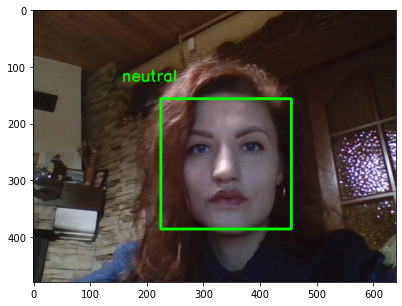

Камера запущена


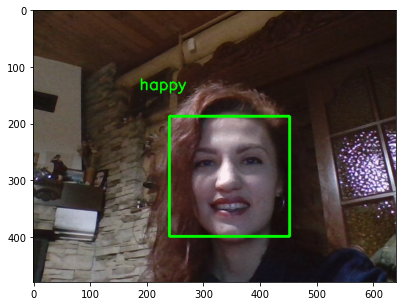

Камера запущена


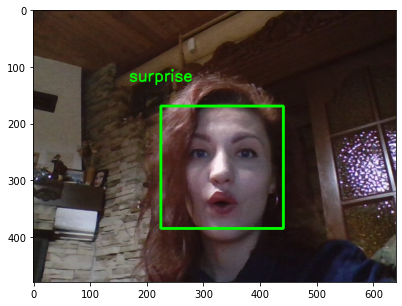

Камера запущена


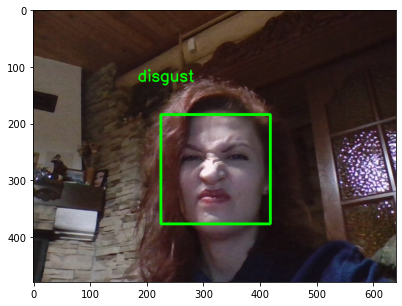

Камера запущена


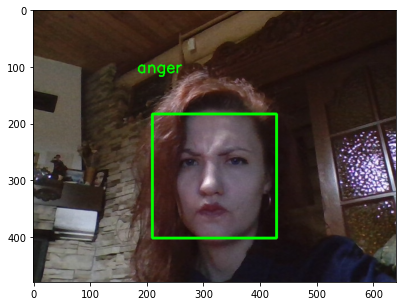

In [ ]:
for i in range(5):
    webcam_emotion.recognize()